In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import confusion_matrix , accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset

In [4]:
df=pd.read_csv(r'https://raw.githubusercontent.com/DataScienceHamburg/AppliedNLPMaterial/master/010_IntroToNLP/data/Tweets.csv').dropna()
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [18]:
BATCH_SIZE = 512
NUM_EPOCHS = 80

In [19]:
cat_id = {'neutral': 1,
          'negative': 0,
          'positive': 2}

df['class'] = df['sentiment'].map(cat_id)

In [20]:
X = df['text'].values
y = df['class'].values
# %% train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state=123)
print(f"X train: {X_train.shape}, y train: {y_train.shape}\nX test: {X_test.shape}, y test: {y_test.shape}")
#%%

X train: (13740,), y train: (13740,)
X test: (13740,), y test: (13740,)


In [21]:
one_hot = CountVectorizer()
X_train_onehot = one_hot.fit_transform(X_train)
X_test_onehot = one_hot.transform(X_test)

In [22]:
class SentimentData(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = torch.Tensor(X.toarray())
        self.y = torch.Tensor(y).type(torch.LongTensor)
        self.len = len(self.X)

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [23]:
train_ds = SentimentData(X= X_train_onehot, y = y_train)
test_ds = SentimentData(X_test_onehot, y_test)


# %% Dataloader
train_loader = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=15000)


In [24]:
class SentimentModel(nn.Module):
    def __init__(self, NUM_FEATURES, NUM_CLASSES, HIDDEN = 10):
        super().__init__()
        self.linear = nn.Linear(NUM_FEATURES, HIDDEN)
        self.linear2 = nn.Linear(HIDDEN, NUM_CLASSES)
        self.relu = nn.ReLU()
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.log_softmax(x)
        return x

In [25]:
model = SentimentModel(NUM_FEATURES = X_train_onehot.shape[1], NUM_CLASSES = 3)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters())

In [26]:
train_losses = []
for e in range(NUM_EPOCHS):
    curr_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred_log = model(X_batch)
        loss = criterion(y_pred_log, y_batch.long())

        curr_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_losses.append(curr_loss)
    print(f"Epoch {e}, Loss: {curr_loss}")

Epoch 0, Loss: 29.204052329063416
Epoch 1, Loss: 28.206714510917664
Epoch 2, Loss: 26.799562215805054
Epoch 3, Loss: 25.063732981681824
Epoch 4, Loss: 23.148396968841553
Epoch 5, Loss: 21.20658439397812
Epoch 6, Loss: 19.383717238903046
Epoch 7, Loss: 17.745757043361664
Epoch 8, Loss: 16.296820402145386
Epoch 9, Loss: 15.036643087863922
Epoch 10, Loss: 13.93929374217987
Epoch 11, Loss: 12.981864213943481
Epoch 12, Loss: 12.12740409374237
Epoch 13, Loss: 11.380362719297409
Epoch 14, Loss: 10.710359394550323
Epoch 15, Loss: 10.104911029338837
Epoch 16, Loss: 9.555405139923096
Epoch 17, Loss: 9.064154207706451
Epoch 18, Loss: 8.612106174230576
Epoch 19, Loss: 8.198501288890839
Epoch 20, Loss: 7.812018066644669
Epoch 21, Loss: 7.462273642420769
Epoch 22, Loss: 7.1315478682518005
Epoch 23, Loss: 6.827758833765984
Epoch 24, Loss: 6.5504651218652725
Epoch 25, Loss: 6.283985331654549
Epoch 26, Loss: 6.042723670601845
Epoch 27, Loss: 5.815955728292465
Epoch 28, Loss: 5.5920558869838715
Epoch 29

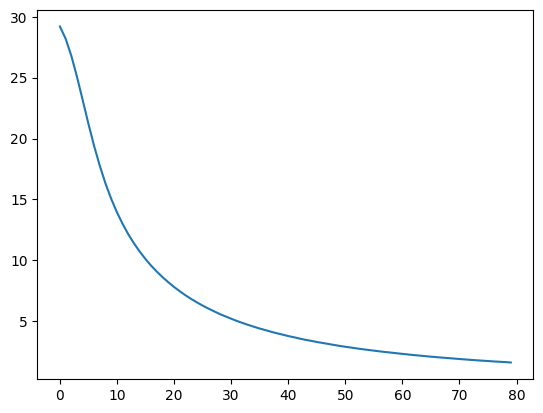

In [27]:
sns.lineplot(x=list(range(len(train_losses))), y= train_losses)
plt.show()

In [28]:
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_test_pred_log = model(X_batch)
        y_test_pred = torch.argmax(y_test_pred_log, dim = 1)

In [30]:
y_test_pred_np = y_test_pred.squeeze().cpu().numpy()

In [31]:
acc = accuracy_score(y_pred=y_test_pred, y_true = y_test)

<Axes: >

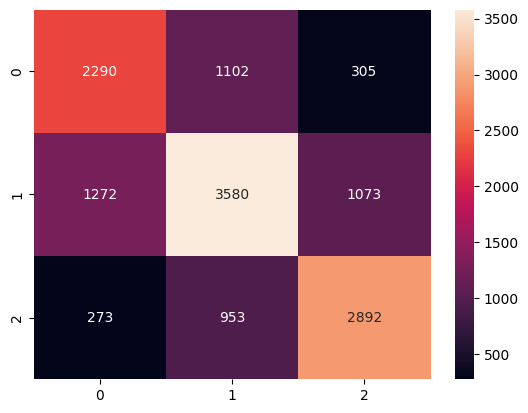

In [32]:
sns.heatmap(confusion_matrix(y_test_pred_np, y_test), annot=True, fmt=".0f")